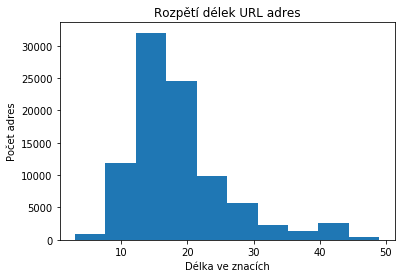

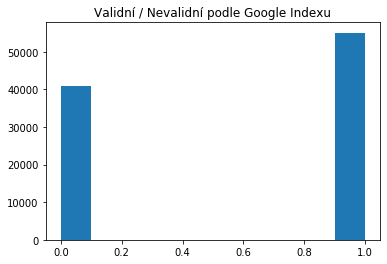

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('dataset.csv')

# Omezím si dataframe jenom na url adresy menší než 50
length_const = df[df['domainLen'] < 50]

# udělám si series
lengths = length_const.iloc[:, 9]

plt.hist(lengths)
plt.title("Rozpětí délek URL adres")
plt.xlabel("Délka ve znacích")
plt.ylabel("Počet adres")
plt.show()
plt.clf()

valid = df.loc[:,'valid']

plt.hist(valid)
plt.title("Validní / Nevalidní podle Google Indexu")
plt.show()